In [ ]:
!pip install torch torchvision numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, Dataset
import random
import time

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load and preprocess a small subset of CIFAR-10 dataset
def load_cifar10_subset(train_size=5000, test_size=1000):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # Load full datasets
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create stratified subsets to maintain class balance
    train_indices = []
    samples_per_class = train_size // 10  # CIFAR-10 has 10 classes

    for class_idx in range(10):
        # Use tensor operations to find indices with this class
        labels = torch.tensor(train_dataset.targets)
        class_indices = torch.where(labels == class_idx)[0].tolist()
        # Randomly select samples_per_class indices
        selected_indices = random.sample(class_indices, min(samples_per_class, len(class_indices)))
        train_indices.extend(selected_indices)

    # Do the same for test set
    test_indices = []
    samples_per_class = test_size // 10

    for class_idx in range(10):
        labels = torch.tensor(test_dataset.targets)
        class_indices = torch.where(labels == class_idx)[0].tolist()
        selected_indices = random.sample(class_indices, min(samples_per_class, len(class_indices)))
        test_indices.extend(selected_indices)

    # Create subset datasets
    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(test_dataset, test_indices)

    print(f"Created training subset with {len(train_subset)} samples")
    print(f"Created testing subset with {len(test_subset)} samples")

    return train_subset, test_subset

In [ ]:
# Create a smaller CNN model for faster training
class SmallCifarCNN(nn.Module):
    def __init__(self):
        super(SmallCifarCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten and fully connected layers
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Simulate federated data by splitting the training data among clients
def create_federated_data(dataset, num_clients=5, iid=True):
    """
    Split the dataset into multiple clients
    iid: If True, data is distributed in an IID manner. If False, data is distributed in a non-IID manner
    """
    num_items = len(dataset)

    if iid:
        # IID: random assignment
        indices = list(range(num_items))
        random.shuffle(indices)
        client_data_indices = np.array_split(indices, num_clients)
        # Convert numpy arrays to lists for type compatibility
        client_data_indices = [indices.tolist() for indices in client_data_indices]
    else:
        # Non-IID: sort by label, then assign
        # Get labels for all items
        if isinstance(dataset, Subset):
            # For Subset, we need to get labels from the original dataset
            original_dataset = dataset.dataset
            if hasattr(original_dataset, 'targets'):
                # Extract labels for the subset indices
                labels = [original_dataset.targets[i] for i in dataset.indices]
            else:
                # Fallback: get labels by iterating through the dataset
                labels = []
                for i in range(len(dataset)):
                    _, label = dataset[i]
                    labels.append(label)
        else:
            # For regular dataset
            if hasattr(dataset, 'targets'):
                labels = dataset.targets
            else:
                # Fallback method
                labels = []
                for i in range(len(dataset)):
                    _, label = dataset[i]
                    labels.append(label)

        # Convert to numpy array for sorting
        labels = np.array(labels)
        sorted_indices = np.argsort(labels)

        # Distribute to ensure each client has mostly one or two classes
        client_data_indices = []
        classes_per_client = 2

        # Assign indices to clients in a skewed manner
        chunks = np.array_split(sorted_indices, num_clients * classes_per_client // 2)
        for i in range(num_clients):
            # Select 2 chunks for this client (to get a skewed distribution)
            chunk1_idx = i % (len(chunks) - 1)
            chunk2_idx = (i + num_clients) % len(chunks)

            client_indices = np.concatenate([
                chunks[chunk1_idx],
                chunks[chunk2_idx]
            ])
            # Convert numpy array to list for type compatibility
            client_data_indices.append(client_indices.tolist())

    # Create a list of Subset datasets
    client_datasets = [Subset(dataset, indices) for indices in client_data_indices]

    # Print distribution information
    print(f"Data distribution among {num_clients} clients:")
    for i, ds in enumerate(client_datasets):
        print(f"  Client {i+1}: {len(ds)} samples")

    return client_datasets

In [ ]:
# Training function for local client update
def train(model, train_loader, epochs, lr=0.01):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        total_loss += running_loss / len(train_loader)
        total_correct += correct
        total_samples += total

    # Return model and metrics
    accuracy = 100. * total_correct / total_samples
    avg_loss = total_loss / epochs
    return model, avg_loss, accuracy

In [ ]:
# Evaluate function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return loss / len(test_loader), accuracy

In [ ]:
# Federated Averaging algorithm
def federated_avg(client_models):
    """
    Perform federated averaging of client models
    """
    # Get the first client's model as a base
    global_model = copy.deepcopy(client_models[0])
    global_dict = global_model.state_dict()

    # Average each parameter across all client models
    for k in global_dict.keys():
        # Initialize with zeros
        global_dict[k] = torch.zeros_like(global_dict[k])

        # Sum all client parameters
        for client_model in client_models:
            global_dict[k] += client_model.state_dict()[k]

        # Take the average
        global_dict[k] = torch.div(global_dict[k], len(client_models))

    # Load the averaged parameters back into the global model
    global_model.load_state_dict(global_dict)
    return global_model

In [ ]:
# Main function to run the federated learning
def run_federated_learning(num_clients=5, num_rounds=5, local_epochs=1, iid=True, train_size=5000, test_size=1000, lr=0.01):
    start_time = time.time()

    # Load the smaller dataset
    print("Loading CIFAR-10 subset...")
    train_dataset, test_dataset = load_cifar10_subset(train_size, test_size)

    # Create federated data
    print(f"Creating federated data with {num_clients} clients (IID={iid})...")
    client_datasets = create_federated_data(train_dataset, num_clients, iid)

    # Create data loaders for each client
    client_dataloaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in client_datasets]

    # Create a test loader
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize the global model
    global_model = SmallCifarCNN().to(device)

    # Training metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    x = []

    # Perform federated learning for multiple rounds
    print(f"Starting federated learning for {num_rounds} rounds...")
    for round_num in range(1, num_rounds + 1):
        round_start = time.time()
        print(f"Round {round_num}/{num_rounds}")

        # Initialize client models with the global model weights
        client_models = []
        client_losses = []
        client_accuracies = []

        # Train each client locally
        for client_idx, dataloader in enumerate(client_dataloaders):
            # Create a new model instance and copy global model weights
            client_model = copy.deepcopy(global_model)

            # Train the client model
            client_model, client_loss, client_accuracy = train(
                client_model, dataloader, epochs=local_epochs, lr=lr
            )

            client_models.append(client_model)
            client_losses.append(client_loss)
            client_accuracies.append(client_accuracy)

            print(f"  Client {client_idx+1}: Loss = {client_loss:.4f}, Accuracy = {client_accuracy:.2f}%")

        if round_num == num_rounds:
            x = client_models

        # Perform federated averaging
        global_model = federated_avg(client_models)

        # Calculate average training metrics for this round
        avg_train_loss = sum(client_losses) / len(client_losses)
        avg_train_acc = sum(client_accuracies) / len(client_accuracies)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Evaluate global model on the test set
        test_loss, test_acc = evaluate(global_model, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        round_end = time.time()
        print(f"  Average training - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.2f}%")
        print(f"  Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
        print(f"  Round completed in {round_end - round_start:.2f} seconds")



    # Save the final global model
    torch.save(global_model.state_dict(), 'federated_cifar10_pytorch_small.pth')
    print("Model saved as 'federated_cifar10_pytorch_small.pth'")

    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    return global_model, x, (train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
# Run the federated learning simulation with smaller dataset and fewer rounds/clients
model, client_models, metrics = run_federated_learning(
    num_clients=5,      # Reduced number of clients
    num_rounds=5,       # Reduced number of rounds
    local_epochs=1,     # Single epoch per client per round
    iid=True,           # Data distribution type
    train_size=5000,    # Small training set (5000 samples instead of 50000)
    test_size=1000      # Small test set (1000 samples instead of 10000)
)

# To run with non-IID data distribution:
# model, metrics = run_federated_learning(num_clients=5, num_rounds=5, local_epochs=1, iid=False, train_size=5000, test_size=1000)

# Print final evaluation
train_dataset, test_dataset = load_cifar10_subset(5000, 1000)
test_loader = DataLoader(test_dataset, batch_size=64)
final_loss, final_accuracy = evaluate(model, test_loader)
print(f"Final model - Test Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.2f}%")

Loading CIFAR-10 subset...
Files already downloaded and verified
Files already downloaded and verified
Created training subset with 5000 samples
Created testing subset with 1000 samples
Creating federated data with 5 clients (IID=True)...
Data distribution among 5 clients:
  Client 1: 1000 samples
  Client 2: 1000 samples
  Client 3: 1000 samples
  Client 4: 1000 samples
  Client 5: 1000 samples
Starting federated learning for 5 rounds...
Round 1/5
  Client 1: Loss = 2.1605, Accuracy = 18.90%
  Client 2: Loss = 2.2021, Accuracy = 16.90%
  Client 3: Loss = 2.1378, Accuracy = 19.40%
  Client 4: Loss = 2.1879, Accuracy = 19.50%
  Client 5: Loss = 2.1564, Accuracy = 18.20%
  Average training - Loss: 2.1689, Accuracy: 18.58%
  Test - Loss: 1.9783, Accuracy: 29.10%
  Round completed in 1.78 seconds
Round 2/5
  Client 1: Loss = 1.9481, Accuracy = 24.40%
  Client 2: Loss = 1.9724, Accuracy = 25.00%
  Client 3: Loss = 1.9012, Accuracy = 28.30%
  Client 4: Loss = 1.9425, Accuracy = 27.60%
  Clie

In [ ]:
# Data recovery attack via model inversion
def model_inversion_attack(model, target_class, learning_rate=0.01, iterations=1000):
    """
    Attempts to reconstruct a representative sample from target_class
    by optimizing an input to maximize the target class probability
    """
    model.eval()  # Set model to evaluation mode

    # Start with random noise as our initial image
    # CIFAR-10 uses 3 channels (RGB) with 32x32 resolution
    recovered_image = torch.rand(1, 3, 32, 32, requires_grad=True, device=device)

    # Define optimizer for the image
    optimizer = optim.Adam([recovered_image], lr=learning_rate)

    # Create one-hot vector for target class
    # CIFAR-10 has 10 classes
    target = torch.zeros(1, 10, device=device)
    target[0, target_class] = 1

    losses = []

    # Optimization loop
    for i in range(iterations):
        optimizer.zero_grad()

        # Get model prediction
        pred = model(recovered_image)

        # Calculate loss (negative log likelihood of target class)
        classification_loss = -torch.sum(target * torch.log(pred + 1e-10))

        # Add regularization to encourage a cleaner image
        tv_loss = torch.sum(torch.abs(recovered_image[:, :, :, :-1] - recovered_image[:, :, :, 1:])) + \
                  torch.sum(torch.abs(recovered_image[:, :, :-1, :] - recovered_image[:, :, 1:, :]))
        tv_loss = tv_loss * 0.001

        l2_loss = torch.sum(recovered_image ** 2) * 0.001

        total_loss = classification_loss + tv_loss + l2_loss

        # Backward pass
        total_loss.backward()

        # Update the image
        optimizer.step()

        # Clip values to valid image range [0, 1]
        with torch.no_grad():
            recovered_image.clamp_(0, 1)

        # Track progress
        if i % 100 == 0:
            losses.append(classification_loss.item())
            print(f"Iteration {i}, Loss: {classification_loss.item():.4f}")

    # Get the final recovered image
    with torch.no_grad():
        recovered_image_np = recovered_image.cpu().squeeze().numpy()

    return recovered_image_np, losses

# Display results
def plot_recovered_images(original_samples, recovered_images, target_classes):
    plt.figure(figsize=(12, 4))

    for i, (orig, rec, target) in enumerate(zip(original_samples, recovered_images, target_classes)):
        # Plot original
        plt.subplot(2, len(target_classes), i + 1)

        # For CIFAR-10, transpose dimensions to get channel-last format for plt.imshow
        if len(orig.shape) == 3 and orig.shape[0] == 3:  # If channel-first (C,H,W)
            orig = orig.transpose(1, 2, 0)  # Convert to (H,W,C)

        # No need for cmap='gray' since CIFAR is RGB
        plt.imshow(orig)
        plt.title(f"Original Class {target}")
        plt.axis('off')

        # Plot recovered
        plt.subplot(2, len(target_classes), i + len(target_classes) + 1)

        # For CIFAR-10, transpose dimensions if needed
        if len(rec.shape) == 3 and rec.shape[0] == 3:  # If channel-first (C,H,W)
            rec = rec.transpose(1, 2, 0)  # Convert to (H,W,C)

        plt.imshow(rec)
        plt.title(f"Recovered Class {target}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
for x in client_models:
    print(x)


Performing model inversion attack for class 0...
Iteration 0, Loss: nan
Iteration 100, Loss: nan
Iteration 200, Loss: nan
Iteration 300, Loss: nan
Iteration 400, Loss: nan
Iteration 500, Loss: nan
Iteration 600, Loss: nan
Iteration 700, Loss: nan
Iteration 800, Loss: nan
Iteration 900, Loss: nan


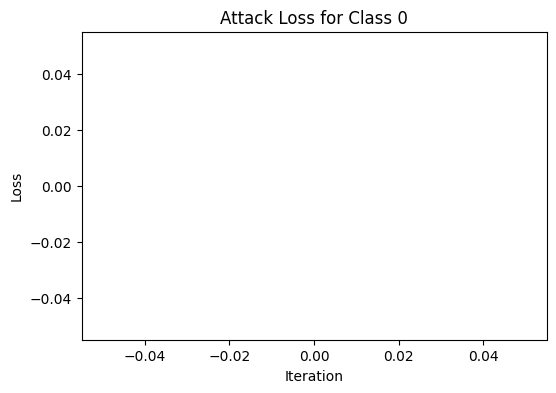


Performing model inversion attack for class 1...
Iteration 0, Loss: nan
Iteration 100, Loss: nan
Iteration 200, Loss: nan
Iteration 300, Loss: nan
Iteration 400, Loss: nan
Iteration 500, Loss: nan
Iteration 600, Loss: nan
Iteration 700, Loss: nan
Iteration 800, Loss: nan
Iteration 900, Loss: nan


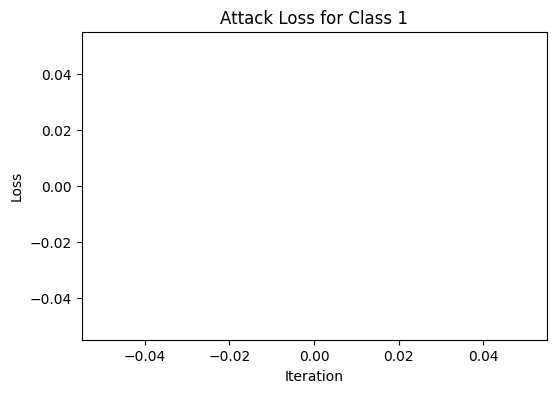


Performing model inversion attack for class 4...
Iteration 0, Loss: nan
Iteration 100, Loss: nan
Iteration 200, Loss: nan
Iteration 300, Loss: nan
Iteration 400, Loss: nan
Iteration 500, Loss: nan
Iteration 600, Loss: nan
Iteration 700, Loss: nan
Iteration 800, Loss: nan
Iteration 900, Loss: nan


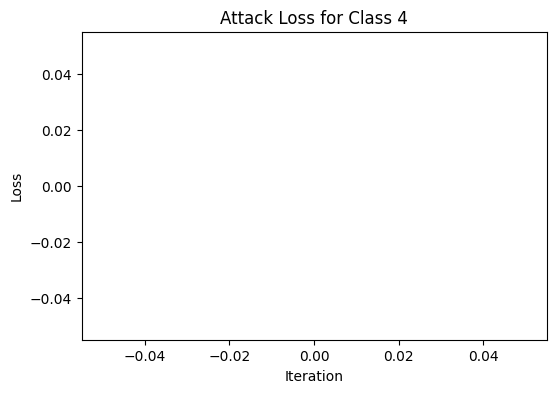


Performing model inversion attack for class 8...
Iteration 0, Loss: nan
Iteration 100, Loss: nan
Iteration 200, Loss: nan
Iteration 300, Loss: nan
Iteration 400, Loss: nan
Iteration 500, Loss: nan
Iteration 600, Loss: nan
Iteration 700, Loss: nan
Iteration 800, Loss: nan
Iteration 900, Loss: nan


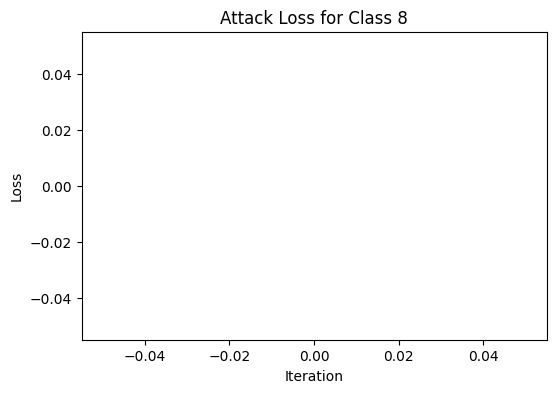

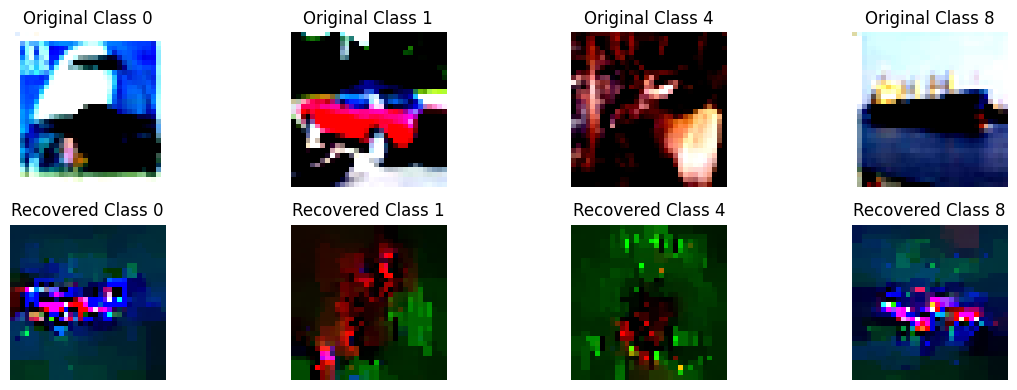


Attack completed. The recovered images represent information leaked from the model.


In [ ]:
# Select target classes to recover
target_classes = [0, 1, 4, 8]  # Digits to recover: 0, 1, 4, 8

# Get example images from each target class
original_samples = []
for target in target_classes:
    for img, label in train_dataset:
        if label == target:
            original_samples.append(img.squeeze().numpy())
            break

    # Perform model inversion attack for each target class
recovered_images = []
for target in target_classes:
    print(f"\nPerforming model inversion attack for class {target}...")
    recovered_image, losses = model_inversion_attack(client_models[0], target)
    recovered_images.append(recovered_image)

    # Plot loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(0, len(losses) * 100, 100), losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Attack Loss for Class {target}')
    plt.show()

# Plot results
plot_recovered_images(original_samples, recovered_images, target_classes)

print("\nAttack completed. The recovered images represent information leaked from the model.")


# Mission 1

1.   Change communication rounds and compare
2.   Change learning rate and compare
3.   Change local epochs and compare
4.   Change learning rate and local epoch but (learning rate * local epoch = a constant) and conclude


In [ ]:
num_clients = 5
num_rounds = 5

model_iid, (train_losses_iid, train_accuracies_iid, test_losses_iid, test_accuracies_iid) = run_federated_learning(
    num_clients=num_clients,
    num_rounds=num_rounds,
    local_epochs=1,
    iid=True,
    train_size=5000,
    test_size=1000,
    lr=0.01
)

model_non_iid, (train_losses_non_iid, train_accuracies_non_iid, test_losses_non_iid, test_accuracies_non_iid) = run_federated_learning(
    num_clients=num_clients,
    num_rounds=num_rounds,
    local_epochs=1,
    iid=False,
    train_size=5000,
    test_size=1000,
    lr=0.01
)

Loading CIFAR-10 subset...
Files already downloaded and verified
Files already downloaded and verified
Created training subset with 5000 samples
Created testing subset with 1000 samples
Creating federated data with 5 clients (IID=True)...
Data distribution among 5 clients:
  Client 1: 1000 samples
  Client 2: 1000 samples
  Client 3: 1000 samples
  Client 4: 1000 samples
  Client 5: 1000 samples
Starting federated learning for 5 rounds...
Round 1/5
  Client 1: Loss = 2.1841, Accuracy = 17.50%
  Client 2: Loss = 2.2160, Accuracy = 18.80%
  Client 3: Loss = 2.2072, Accuracy = 16.80%
  Client 4: Loss = 2.2059, Accuracy = 18.00%
  Client 5: Loss = 2.1743, Accuracy = 18.90%
  Average training - Loss: 2.1975, Accuracy: 18.00%
  Test - Loss: 2.0639, Accuracy: 26.70%
  Round completed in 1.93 seconds
Round 2/5
  Client 1: Loss = 1.9413, Accuracy = 25.10%
  Client 2: Loss = 1.9653, Accuracy = 27.90%
  Client 3: Loss = 1.9713, Accuracy = 27.50%
  Client 4: Loss = 1.9904, Accuracy = 24.40%
  Clie

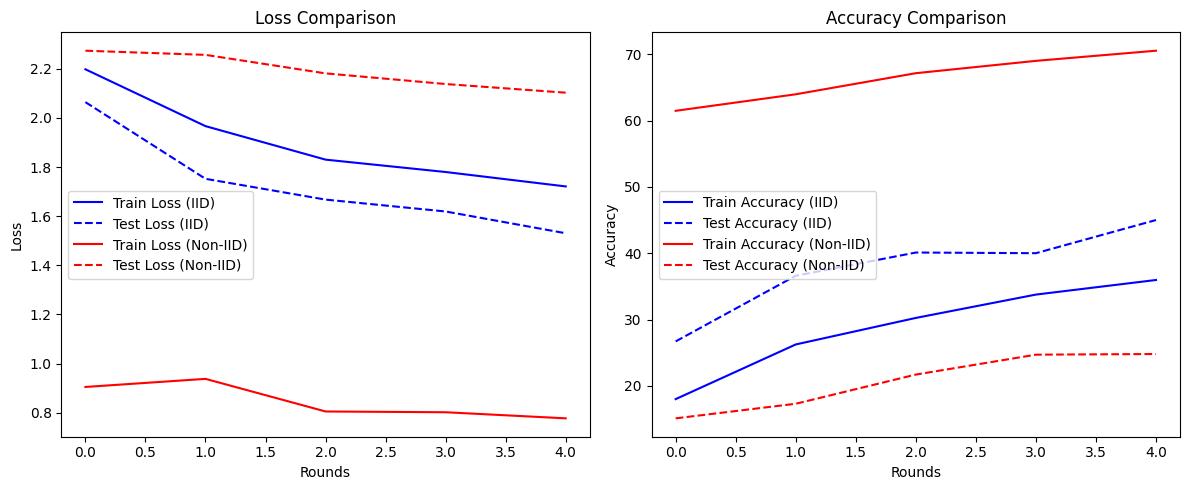

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(num_rounds), train_losses_iid, label='Train Loss (IID)', color='blue')
axes[0].plot(range(num_rounds), test_losses_iid, label='Test Loss (IID)', color='blue', linestyle='dashed')
axes[0].plot(range(num_rounds), train_losses_non_iid, label='Train Loss (Non-IID)', color='red')
axes[0].plot(range(num_rounds), test_losses_non_iid, label='Test Loss (Non-IID)', color='red', linestyle='dashed')
axes[0].set_title('Loss Comparison')
axes[0].set_xlabel('Rounds')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(range(num_rounds), train_accuracies_iid, label='Train Accuracy (IID)', color='blue')
axes[1].plot(range(num_rounds), test_accuracies_iid, label='Test Accuracy (IID)', color='blue', linestyle='dashed')
axes[1].plot(range(num_rounds), train_accuracies_non_iid, label='Train Accuracy (Non-IID)', color='red')
axes[1].plot(range(num_rounds), test_accuracies_non_iid, label='Test Accuracy (Non-IID)', color='red', linestyle='dashed')
axes[1].set_title('Accuracy Comparison')
axes[1].set_xlabel('Rounds')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Mission 2

1.   Change iid dataset to non-iid dataset and compare
2.   Conduct similar experiences with mission 1

Loading CIFAR-10 subset...
Files already downloaded and verified
Files already downloaded and verified
Created training subset with 5000 samples
Created testing subset with 1000 samples
Creating federated data with 5 clients (IID=False)...
Data distribution among 5 clients:
  Client 1: 2000 samples
  Client 2: 2000 samples
  Client 3: 2000 samples
  Client 4: 2000 samples
  Client 5: 2000 samples
Starting federated learning for 5 rounds...
Round 1/5
  Client 1: Loss = 0.7743, Accuracy = 73.50%
  Client 2: Loss = 1.0168, Accuracy = 57.50%
  Client 3: Loss = 0.8841, Accuracy = 62.25%
  Client 4: Loss = 0.7787, Accuracy = 68.95%
  Client 5: Loss = 1.3293, Accuracy = 41.45%
  Average training - Loss: 0.9566, Accuracy: 60.73%
  Test - Loss: 2.2928, Accuracy: 11.30%
  Round completed in 3.63 seconds
Round 2/5
  Client 1: Loss = 0.6503, Accuracy = 77.80%
  Client 2: Loss = 0.9108, Accuracy = 62.55%
  Client 3: Loss = 0.8812, Accuracy = 62.90%
  Client 4: Loss = 0.7304, Accuracy = 71.75%
  Cli

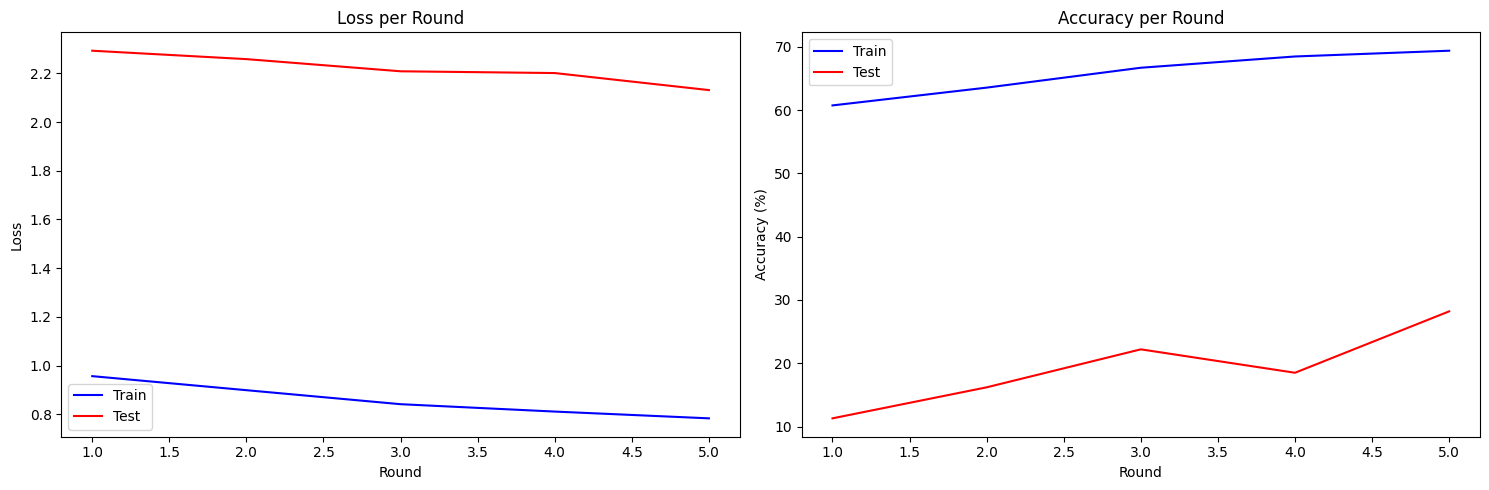

Model saved as 'federated_cifar10_pytorch_small.pth'
Total training time: 20.53 seconds
Files already downloaded and verified
Files already downloaded and verified
Created training subset with 5000 samples
Created testing subset with 1000 samples
Final model - Test Loss: 2.1141, Test Accuracy: 27.00%


In [ ]:
model, (train_losses, train_accuracies, test_losses, test_accuracies) = run_federated_learning(
    num_clients=5,
    num_rounds=5,
    local_epochs=1,
    iid=False,
    train_size=5000,
    test_size=1000
)

train_dataset, test_dataset = load_cifar10_subset(5000, 1000)
train_dataset, test_dataset = load_cifar10_subset(5000, 1000)train_dataset, test_dataset = load_cifar10_subset(5000, 1000)
test_loader = DataLoader(test_dataset, batch_size=64)
final_loss, final_accuracy = evaluate(model, test_loader)
print(f"Final model - Test Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.2f}%")

# Mission 3

Explain Fedavg algorithm by your own understanding (ask GPT if you do not understant the functions, e.g. copy, state_dict, etc).


In [ ]:
def _federated_avg(client_models):
    """
    Perform federated averaging of client models
    This function computes the average of the model parameters from all clients.
    The averaged model is then returned as the global model.
    """
    # Get the first client's model as a base for global mobel
    global_model = copy.deepcopy(client_models[0])

    # Get the global model parameters
    global_dict = global_model.state_dict()

    # Iterate over each parameter in the global mobel's state_dict
    for k in global_dict.keys():

        # Initialize parameter k of global mobel to zeros
        global_dict[k] = torch.zeros_like(global_dict[k])

        # Sum all client parameters k
        for client_model in client_models:
            # Add corresponding parameter k from current client model to global sum
            global_dict[k] += client_model.state_dict()[k]

        # Take the average by dividing by the number of clients
        global_dict[k] = torch.div(global_dict[k], len(client_models))

    # Once all parameters are averaged, load the averaged parameters back into the global model
    global_model.load_state_dict(global_dict)

    # Return updated global model with averaged parameters
    return global_model